### Выполнил: Филоненко Никита

-----
#### Решение на GitHub
Ссылка: [КЛИК](https://github.com/nikfilonenko/EDA_binary-text-classifier/tree/4cabc868800d84bbd1d62ef9d4b7c66662ac9235)

![](../../assets/repository.png)

# Содержание
#### [**Задание**](#01)
1. [**EDA (Exploratory Data Analysis)**](#02)
    - [**Получение общего представления о данных**](#02.1)
        - [**Базовая информация (Пропуски, дубликаты, datatypes)**](#02.1.1)
    - [**Получение более подробной информации о данных**](#02.2)
        - [**Топ-15 банков по числу отзывов**](#02.2.1)
        - [**Банк с самым высоким средним рейтингом из топ-15**](#02.2.2)
        - [**Вывод об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов**](#02.2.3)
    - [**Дополнительный EDA**](#02.3)
2. [**Построение модели бинарной текстовой классификации**](#03)
    - [**Подготовка данных**](#03.1)
    - [**С применением Logistic Regression**](#03.2)
    - [**На PyTorch с применением RNN LSTM**](#03.3)

# Задание <a class="anchor" id="01"></a>

### Анализ отзывов на банки

В данных представлены отзывы, структура:
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

-----

#### Часть 1: Предварительный анализ данных
Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

-----

#### Часть 2: Построение модели бинарной текстовой классификации

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

# Решение

## Импортирование необходимых модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F

# 1. EDA (Exploratory Data Analysis) <a class="anchor" id="02"></a>

### 1.1 Получение общего представления о данных

In [2]:
data = pd.read_csv("../../src/data/parsed_reviews3.csv", sep=',')

#### 1.1.1 Базовая информация (Пропуски, дубликаты, datatypes)

In [3]:
data

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36
...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [5]:
data["body"].head(1)

0    &lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...
Name: body, dtype: object

In [6]:
data.isna().sum()

body         0
title        0
rating       0
bank_name    0
date         0
dtype: int64

**Исходя из полученной информации можно сделать вывод, что пропусков в данных нет, однако, я заметил, что столбец *`date`* имеет некорректный datatype для отображения даты (в виде строки), чтобы избежать ряда проблем (например, при работе с временными интервалами) нужно его преобразовать в тип данных `datetime`**

- **Также в столбце `body`, который представляет собой сами отзывы, имеется большое количество различных `html-тегов` и других лишних символов. Для построения модели бинарной классификации нужно провести лемматизацию текста, а также выполнить фильтрацию отзывов с использованием регулярных выражений для извлечения ненужных тегов и символов :)**

- **Преобразуем столбец `date` в нужный тип данных:**

In [7]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

body                 object
title                object
rating                int64
bank_name            object
date         datetime64[ns]
dtype: object

- **Проверим ***наличие дубликатов*** в данных**

In [8]:
data.duplicated().sum()

62

- **Выведем их**

In [9]:
data[data.duplicated(keep=False)]

,body,title,rating,bank_name,date
898,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
899,&lt;p&gt;Обратился 3 декабря в районе 19 часов...,открытие счёта и получение банковской карты,5,Хоум Кредит Банк,2022-12-30 16:16:13
996,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
997,&lt;p&gt;С самого открытия являемся клиентами ...,"Сняли деньги за перевод физ.лицу, а услугу не ...",1,Норвик Банк,2022-12-30 14:06:33
1610,&lt;p&gt;22.12.2022 в чате своего ЛК мобильног...,Отсутствие информации о порядке конвертации ва...,2,Росбанк,2022-12-29 15:03:06
...,...,...,...,...,...
77358,"&lt;p&gt;Добрый вечер, сегодня я хотел бы расс...",Моё мнение о банке,5,Тинькофф Банк,2022-10-20 18:33:45
85894,Здравствуйте! Хочу поблагодарить сотрудника Хо...,Оформление онлайн потребительского кредита,5,Хоум Кредит Банк,2022-09-25 18:48:43
85895,Здравствуйте! Хочу поблагодарить сотрудника Хо...,Оформление онлайн потребительского кредита,5,Хоум Кредит Банк,2022-09-25 18:48:43
90270,Давно являюсь клиентом Совкомбанка всегда отзы...,Один из лучших банков,5,Совкомбанк,2022-09-10 14:26:29


**Необходимо избавиться от дубликатов, поскольку это может привести к переобучению модели, а также к искажению статистических показателей**

- **Отбросим дубликаты**

In [10]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### 1.2 Получение более подробной информации о данных <a class="anchor" id="02.2"></a>

А именно:

- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов

#### `1.2.1` ТОП-15 банков по числу отзывов <a class="anchor" id="02.2.1"></a>

In [11]:
reviews_per_bank = data.groupby(['bank_name']).agg({'bank_name': ['count']})
reviews_per_bank.columns = ['count']
reviews_per_bank = reviews_per_bank.sort_values(by='count', ascending=False).head(15)

reviews_per_bank = reviews_per_bank.reset_index()

reviews_per_bank.index += 1

reviews_per_bank

,bank_name,count
1,Тинькофф Банк,44852
2,Хоум Кредит Банк,9301
3,Совкомбанк,6100
4,ВТБ,3814
5,СберБанк,3487
6,Альфа-Банк,3368
7,Россельхозбанк,3062
8,Банк Открытие,1894
9,МТС Банк,1542
10,Модульбанк,1452


**Визуализируем**

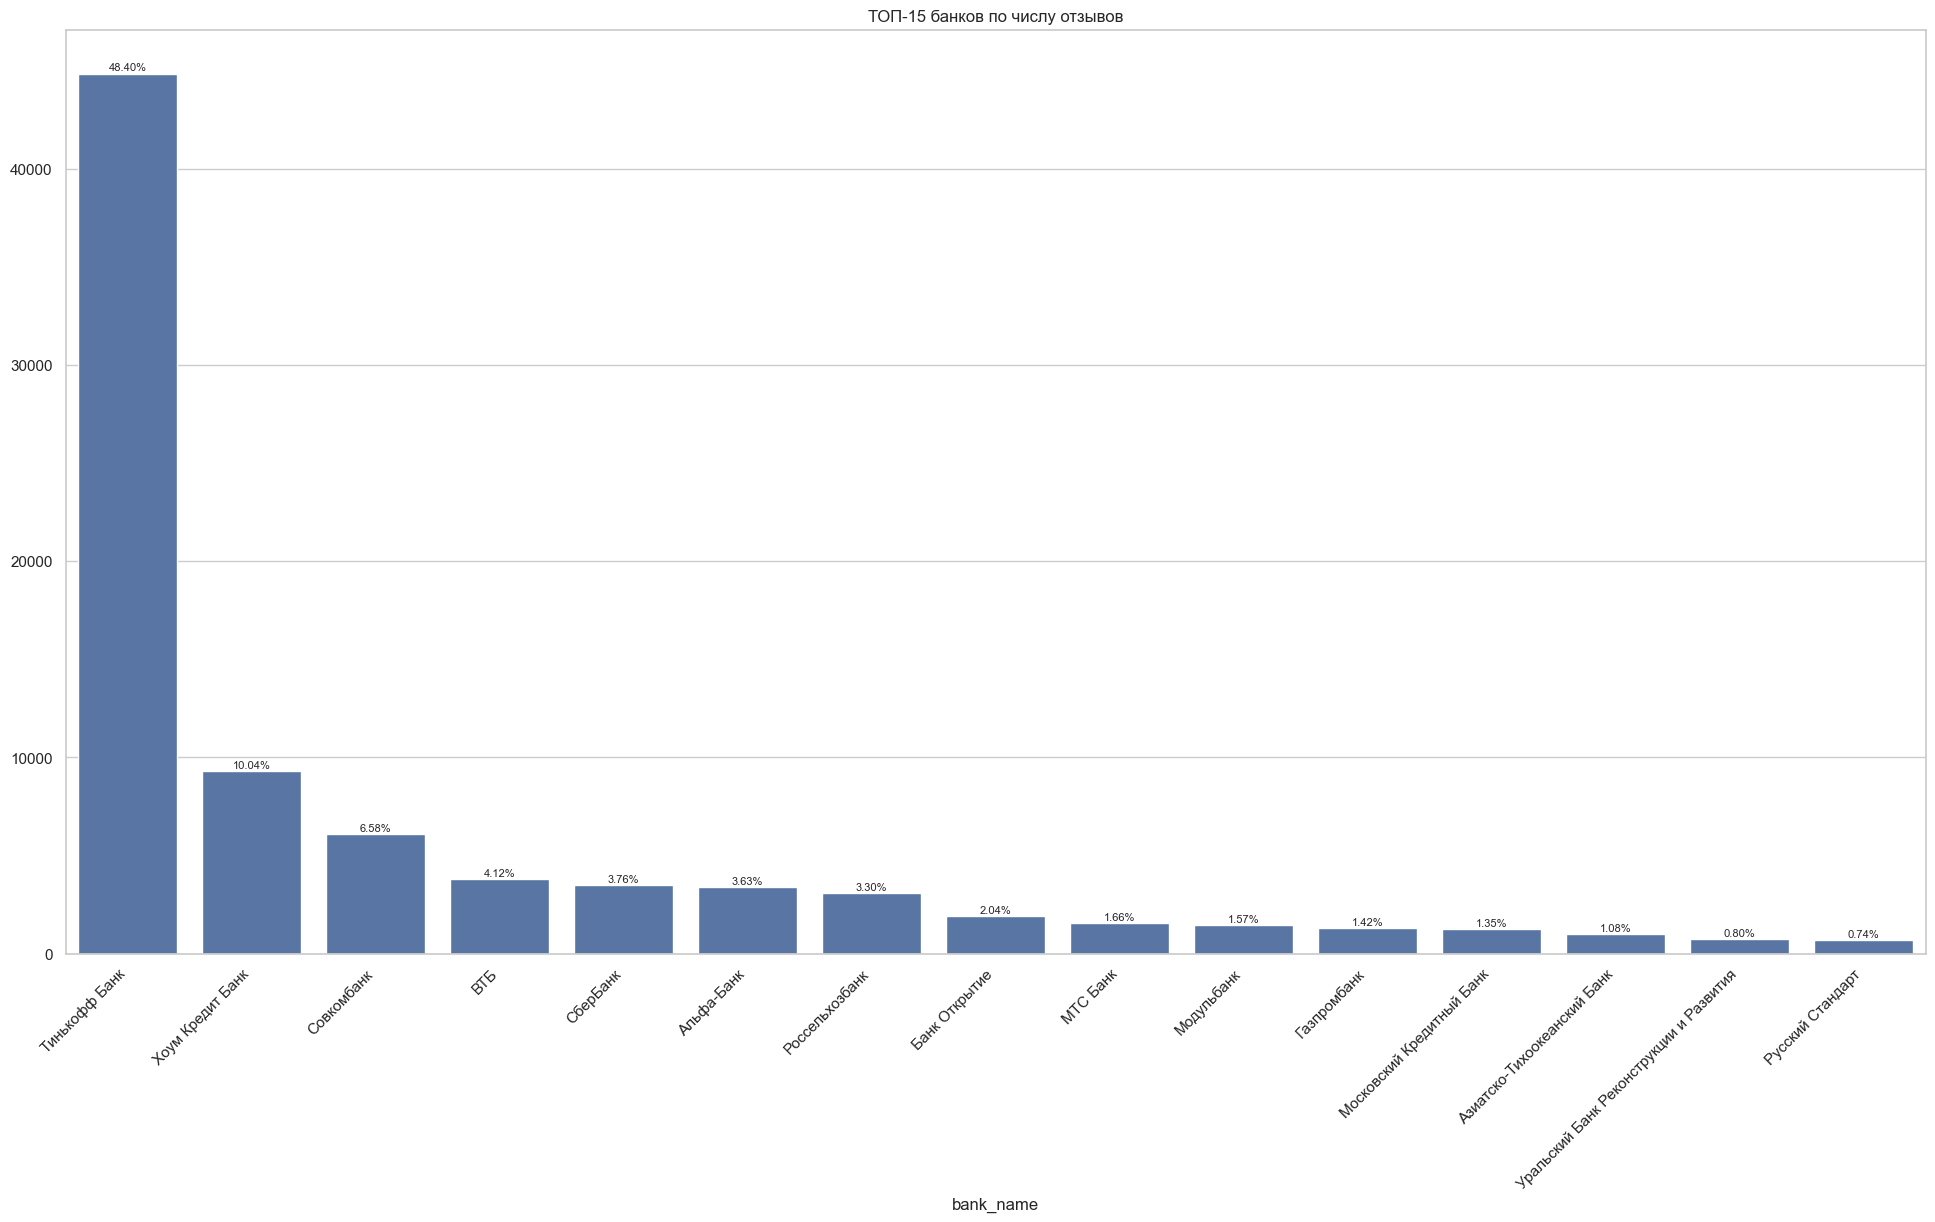

In [12]:
reviews_bank = data['bank_name'].value_counts()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(24, 12))
ax = sns.barplot(x=reviews_bank.head(15).index, y=reviews_bank.head(15).values)

plt.xticks(rotation=45, ha='right')
plt.title('ТОП-15 банков по числу отзывов')

total_reviews = len(data['bank_name'])
for i, value in enumerate(reviews_bank.head(15).values):
    percentage = (value / total_reviews) * 100
    ax.text(i, value + 50, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()


**Исходя из представленной столбчатой диаграммы, хочу сразу выделить необыкновенно большое количество отзывов о Тинькофф Банке - 48.4%. На мой взгляд, это немного необычно поскольку он имеет уж слишком большой отрыв от остальных.**

- **Необходимо проверить на дисбаланс в данных (неравномерное распределение между классами целевой переменной: положительные, отрицательные отзывы)**
- Возможно придется использовать `undersampling`, `кросс-валидацию с учетом стратификации`, `взвешивание классов`

#### `1.2.2` Банк с самым высоким средним рейтингом из топ-15 <a class="anchor" id="02.2.2"></a>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


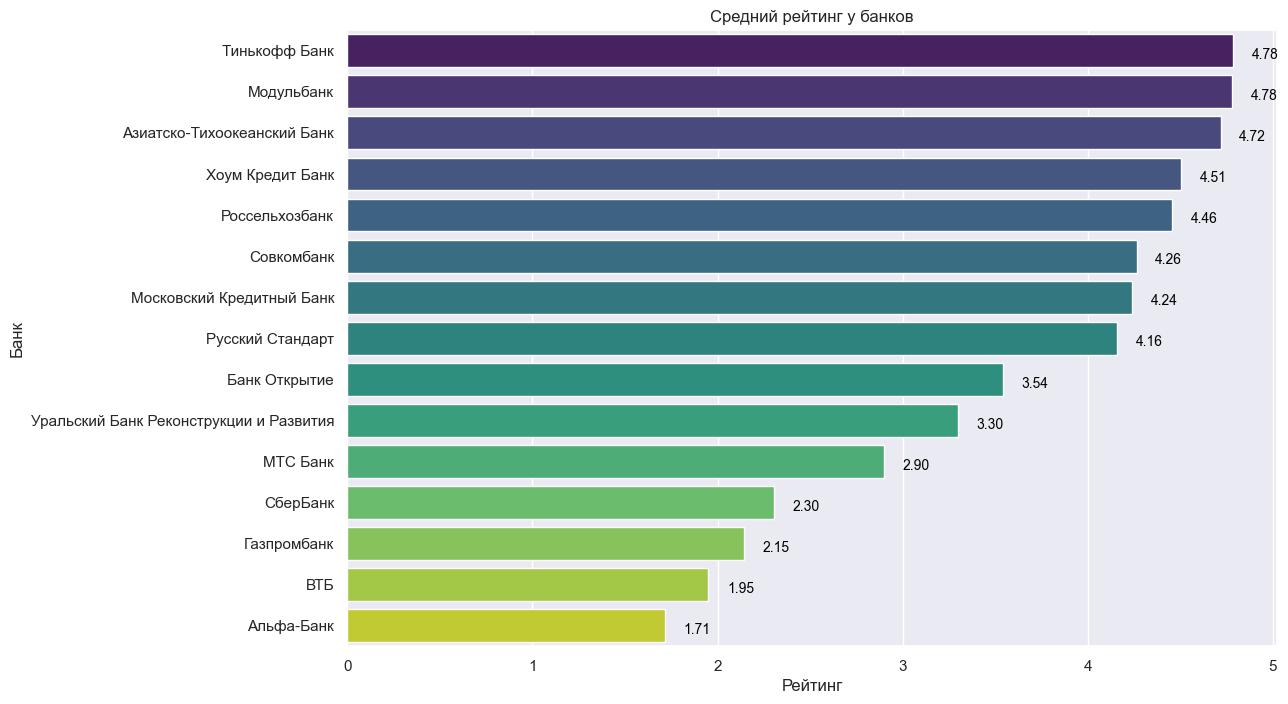

In [13]:
reviews_per_bank = data['bank_name'].value_counts()
reviews_per_bank_df = pd.DataFrame({'bank_name': reviews_per_bank.index, 'review_count': reviews_per_bank.values})

top_banks = reviews_per_bank_df.head(15)

top_banks = top_banks.copy()

top_banks.loc[:, 'mean_rating'] = top_banks['bank_name'].apply(
    lambda bank_name: data[data['bank_name'] == bank_name]['rating'].mean()).values

top_banks.sort_values(by='mean_rating', ascending=False, inplace=True)

names = top_banks['bank_name']
y_pos = np.arange(len(top_banks['bank_name']))
performance = top_banks['mean_rating']

sns.set_theme()

# Создание графика
plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(top_banks['bank_name']))  # Выбор цветовой палитры

# Построение горизонтальной столбчатой диаграммы с использованием seaborn
sns.barplot(x='mean_rating', y='bank_name', data=top_banks, palette=colors, hue='bank_name', dodge=False)

# Удаление легенды
plt.legend().set_visible(False)

# Добавление текста с рейтингом над столбцами
for i, (value, name) in enumerate(zip(top_banks['mean_rating'], top_banks['bank_name'])):
    plt.text(value + 0.1, i + 0.1, f'{value:.2f}', color='black', fontsize=10, va='center')

# Настройка осей и добавление заголовка
plt.xlabel('Рейтинг')
plt.ylabel('Банк')
plt.title('Средний рейтинг у банков')

# Отображение графика
plt.show()

**На первый взгляд, `Тинькофф банк` и `Модульбанк` делят первое место по рейтингу из топ-15 (Хотя по цветой гамме уже заметно, что это не совсем так)**

- **Чтобы убедиться в этом, посчитаем средний рейтинг с точностью до 6-ти знаков после запятой**

In [14]:
reviews_per_bank = data['bank_name'].value_counts()
reviews_per_bank_df = pd.DataFrame({'bank_name': reviews_per_bank.index, 'review_count': reviews_per_bank.values})

top_banks = reviews_per_bank_df.head(15)

top_banks = top_banks.copy()

top_banks.loc[:, 'mean_rating'] = top_banks['bank_name'].apply(
    lambda bank_name: data[data['bank_name'] == bank_name]['rating'].mean())

top_banks.sort_values(by='mean_rating', ascending=False, inplace=True)

print(top_banks[['bank_name', 'mean_rating']])

                                  bank_name  mean_rating
0                             Тинькофф Банк     4.783622
9                                Модульбанк     4.778926
12              Азиатско-Тихоокеанский Банк     4.718000
1                          Хоум Кредит Банк     4.505645
6                            Россельхозбанк     4.455585
2                                Совкомбанк     4.264098
11                Московский Кредитный Банк     4.240192
14                         Русский Стандарт     4.158200
7                             Банк Открытие     3.543295
13  Уральский Банк Реконструкции и Развития     3.298928
8                                  МТС Банк     2.901427
4                                  СберБанк     2.304847
10                              Газпромбанк     2.145358
3                                       ВТБ     1.950970
5                                Альфа-Банк     1.714371


In [15]:
rating_1 = top_banks.iloc[0]['mean_rating']  # Средний рейтинг банка на первом месте
rating_2 = top_banks.iloc[1]['mean_rating']  # Средний рейтинг банка на втором месте

percentage_superiority = ((rating_1 - rating_2) / abs(rating_2)) * 100

print(f"Процентное превосходство {Fore.YELLOW}{top_banks.iloc[0]['bank_name']}{Style.RESET_ALL} над {Fore.YELLOW}{top_banks.iloc[1]['bank_name']}{Style.RESET_ALL}: {Fore.GREEN}{percentage_superiority:.6f}%{Style.RESET_ALL}")

Процентное превосходство Тинькофф Банк над Модульбанк: 0.098266%


**Как можно заметить, Тинькофф все-таки превосходит по рейтингу отзывов своего конкурента в лице `Модульбанка`. Разница, составляет 0.004696 ≈ `0.098266%`**

#### `1.2.3` Вывод об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов <a class="anchor" id="02.2.3"></a>

**Рассчитаем, на какой временной промежуток (в месяцах) распространяются представленные в данных сведения** 

In [16]:
min_date = data['date'].min()
max_date = data['date'].max()

min_date_period = min_date.to_period('M')
max_date_period = max_date.to_period('M')
duration_in_months = (max_date_period - min_date_period).n + 1

min_date_year = min_date.strftime("%d %B %Y")
max_date_year = max_date.strftime("%d %B %Y")

print(f"Данные представлены с {Fore.YELLOW}{min_date_year}{Style.RESET_ALL} по {Fore.CYAN}{max_date_year}{Style.RESET_ALL}")
print(f"\n{Fore.BLUE}Продолжительность данных:{Style.RESET_ALL} {duration_in_months:.2f} месяцев")


date_periods = pd.period_range(min_date.to_period('M'), max_date.to_period('M'), freq='M')

print(f"\n{Fore.GREEN}Месяцы в данных:{Style.RESET_ALL}")
for date_period in date_periods:
    print(f"{date_period.strftime('%B %Y')}")

Данные представлены с 02 September 2022 по 03 January 2023

Продолжительность данных: 5.00 месяцев

Месяцы в данных:
September 2022
October 2022
November 2022
December 2022
January 2023


In [17]:
def calculate_top_banks_avg_rating(data, top_banks, top_count=5):
    data = data.assign(
        month=data['date'].dt.month,
        year=data['date'].dt.year
    )

    top_banks_data = top_banks.sort_values('review_count', ascending=False).head(top_count)

    grouped_data = data.groupby(['bank_name', 'month', 'year'])['rating'].mean().reset_index()

    top_banks_data = grouped_data[grouped_data['bank_name'].isin(top_banks_data['bank_name'])]

    result_data = pd.pivot_table(top_banks_data, values='rating', index=['month', 'year'], columns='bank_name').reset_index()

    result_data = result_data[::-1]
    result_data.reset_index(drop=True)

    return result_data

In [18]:
result_data = calculate_top_banks_avg_rating(data, top_banks)

result_data.index += 1

result_data

bank_name,month,year,ВТБ,СберБанк,Совкомбанк,Тинькофф Банк,Хоум Кредит Банк
5,12,2022,1.898223,1.870871,4.524412,4.650367,4.626565
4,11,2022,1.993778,2.562708,4.230511,4.841598,4.001401
3,10,2022,1.914620,2.777547,3.846561,4.865863,3.591479
2,9,2022,2.073814,1.920000,3.882129,3.888102,4.058275
1,1,2023,1.148148,1.400000,4.419355,3.990291,2.833333


In [19]:
result_data.describe()

bank_name,month,year,ВТБ,СберБанк,Совкомбанк,Тинькофф Банк,Хоум Кредит Банк
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.600000,2022.200000,1.805716,2.106225,4.180593,4.447244,3.822211
std,4.393177,0.447214,0.374185,0.558542,0.307558,0.472615,0.664443
min,1.000000,2022.000000,1.148148,1.400000,3.846561,3.888102,2.833333
25%,9.000000,2022.000000,1.898223,1.870871,3.882129,3.990291,3.591479
50%,10.000000,2022.000000,1.914620,1.920000,4.230511,4.650367,4.001401
75%,11.000000,2022.000000,1.993778,2.562708,4.419355,4.841598,4.058275
max,12.000000,2023.000000,2.073814,2.777547,4.524412,4.865863,4.626565


**Визуализируем**

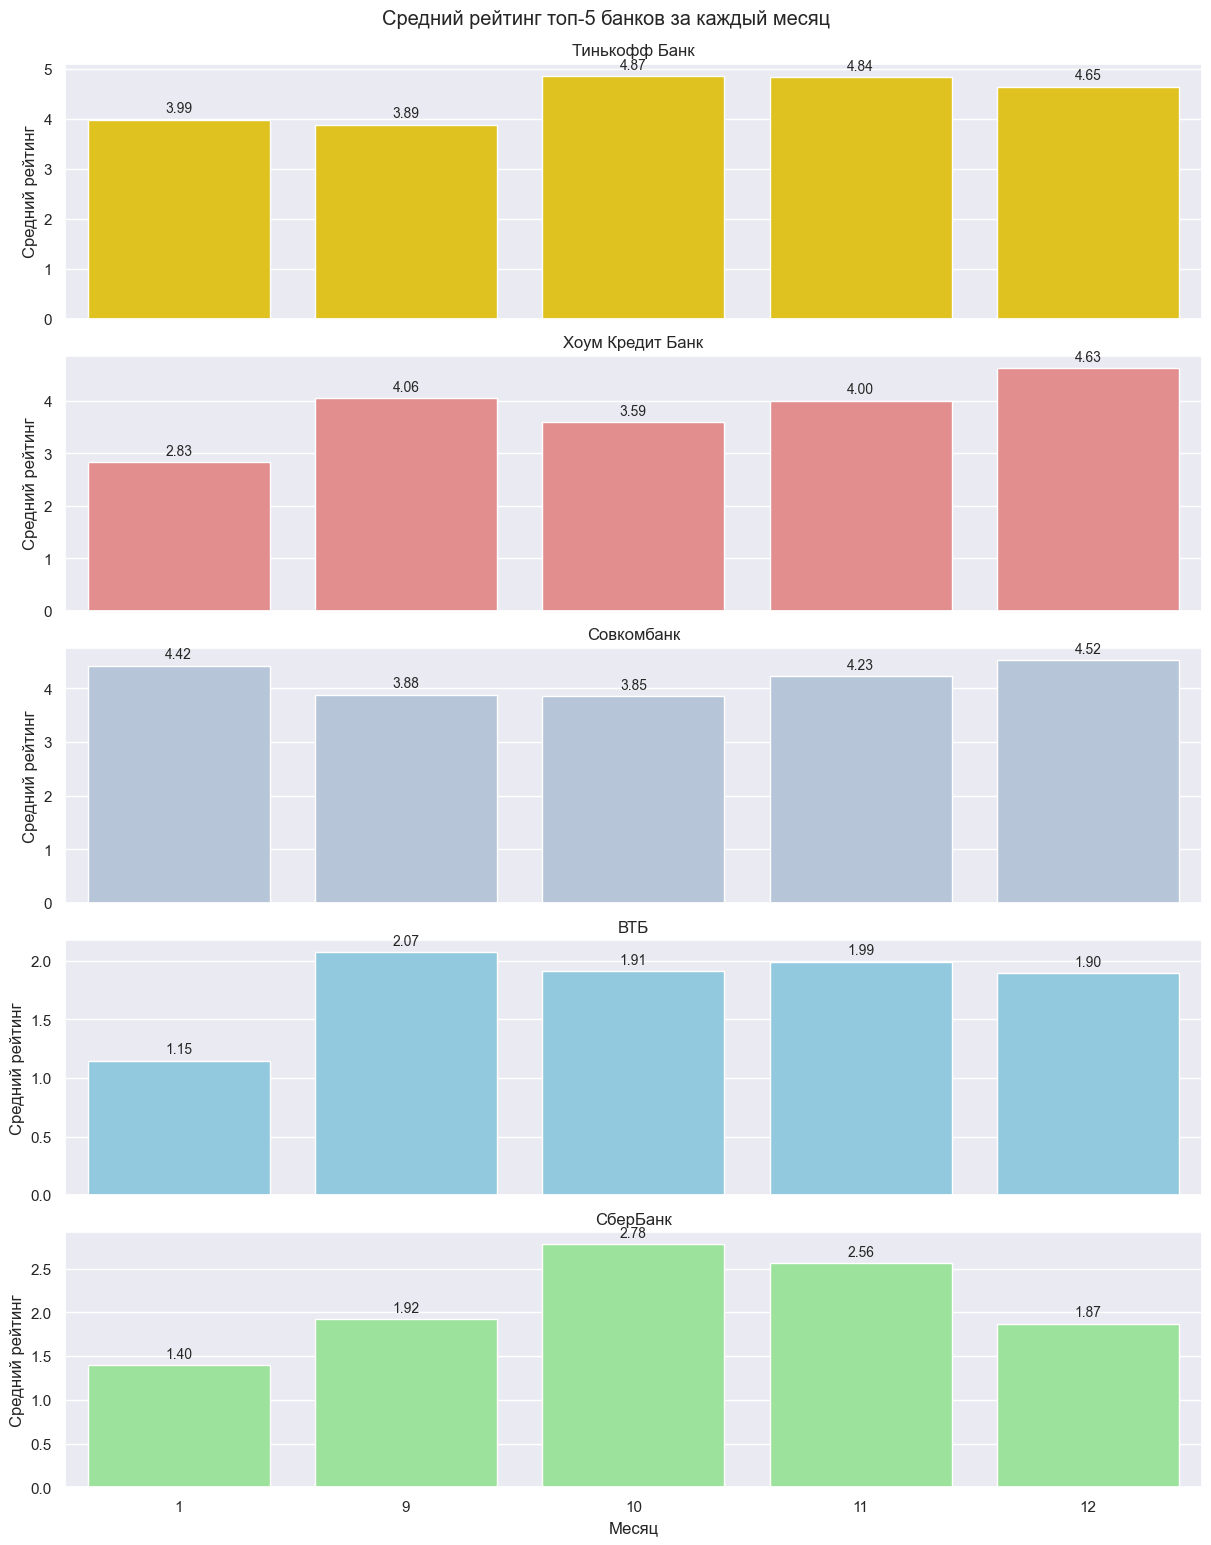

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True, constrained_layout=True)

colors = ['gold', 'lightcoral', 'lightsteelblue', 'skyblue', 'lightgreen']

for i, (bank_name, color) in enumerate(zip(reviews_per_bank_df['bank_name'].head(5), colors)):
    sns.barplot(data=result_data, x='month', y=bank_name, ax=axes[i], color=color)
    
    for bar in axes[i].patches:
        axes[i].annotate(format(bar.get_height(), '.2f'),
                         (bar.get_x() + bar.get_width() / 2,
                          bar.get_height()), ha='center', va='center',
                         size=10, xytext=(0, 8),
                         textcoords='offset points')
    
    axes[i].set_title(bank_name)
    axes[i].set_ylabel('Средний рейтинг')

plt.suptitle('Средний рейтинг топ-5 банков за каждый месяц', y=1.02)
plt.xlabel('Месяц')

plt.show()

**На основе представленной информации, я могу сделать вывод, что:**
1. У **Тинькофф банка**, начиная с сентября, за 5 месяцев были определенные положительные результаты, которые способствовали удовлетворенности клиентов, но, к сожалению, к январю рейтинг банка снизился и почти вернулся к исходной точке. Возможно компании стоит пересмотреть операционные процессы и сконцентрироваться на потребностях конечного пользователя, чтобы вновь повышать рейтинг.
2. Насчет ситуации **Хоум Кредит банка**, здесь все довольно проблематично, поскольку резкое падение рейтинга (почти в два раза - **с 4.63 до 2.83**) за один месяц (с декабря по январь) говорит также о возможной "неправильной" операционной деятельности компании, стоит глубже проанализировать и выявить основные проблемы, с которыми сталкиваются конечные пользователи.
3. Единственная, на мой взгляд, более менее положительная и стабильная ситуация у **Совкомбанка**. Да, безусловно, есть некоторые моменты (рейтинг банка снизился на `0.1` с декабря по январь), но все же, я считаю, что у него неплохой рост рейтинга, по крайней мере лучший из топ-5.
4. У **ВТБ** все достаточно плохо, поскольку рейтинг банка неумолимо падал вниз, если сравнивать показатели с сентября по январь, можно зафиксировать падение почти в 2 раза.
5. **Сбербанк** в начале показывал положительную динамику, но, к сожалению, к январю рейтинг банка снизился ниже исходной точки на `0.52`.

### Дополнительный EDA

#### `1.3.1` Проверка на дисбаланс (неравномерное распределение между классами целевой переменной: положительные, отрицательные отзывы)

In [21]:
data.loc[:, 'info_rating'] = data['rating'].map(
    lambda rating: 1 if rating >= 3 else 0
)

data = data.copy()

positive_reviews = data['info_rating'].sum()
negative_reviews = data['info_rating'].count() - positive_reviews

print(f"Количество положительных отзывов: {Fore.GREEN}{positive_reviews}{Style.RESET_ALL}")
print(f"Количество отрицательных отзывов: {Fore.YELLOW}{negative_reviews}{Style.RESET_ALL}")


Количество положительных отзывов: 71848
Количество отрицательных отзывов: 20825


C:\Users\nikdf\AppData\Local\Temp\ipykernel_24472\4210806629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'info_rating'] = data['rating'].map(


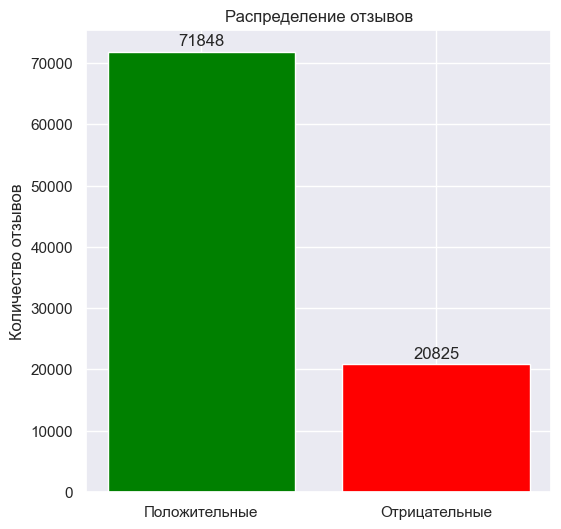

In [22]:
plt.figure(figsize=(6, 6))

plt.bar(['Положительные', 'Отрицательные'], [positive_reviews, negative_reviews], color=['green', 'red'])

for i, value in enumerate([positive_reviews, negative_reviews]):
    plt.text(i, value + 500, str(value), ha='center', va='bottom')

plt.title('Распределение отзывов')
plt.ylabel('Количество отзывов')

plt.show()

**Да, в данной ситуации наблюдается дисбаланс данных между положительными и отрицательными отзывами, необходимо принять меры, поскольку дисбаланс в данных может повлиять на качество обучение модели (смещение в сторону доминирующего класса), особенно если модель чувствительна к различиям в количестве образцов для каждого класса.**

- P.s. основные шаги по этой ситуации предпринимаются во второй части задания :)

#### `1.3.2` Корреляция между длиной отзыва и оценкой

**Перед тем как преступим к проверки корреляционного отношения, нужно проверить данные на соответствие нормальному закону распределения**

- Выполнять такую проверку нужно обязательно, так как только для нормально распределенных данных мы можем в дальнейшем использовать общепринятые статистические процедуры анализа

**Создадим столбец с длинной отзывов**

In [23]:
data['review_length'] = data['body'].apply(len)


Результаты теста Шапиро-Уилка:
Statistic: 0.6309
P-value: 4.9125e-149

Отклоняем нулевую гипотезу: Распределение не является нормальным.


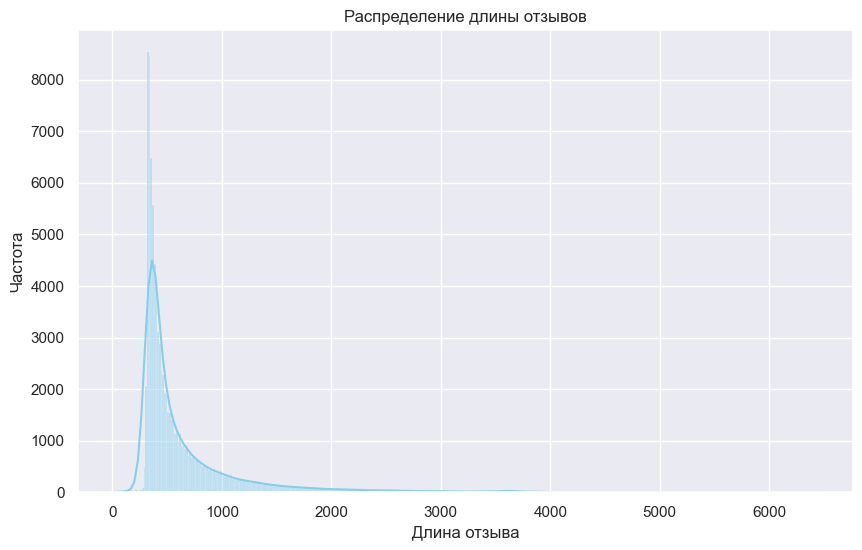

In [25]:
from scipy.stats import shapiro
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stat, p_value = shapiro(data['review_length'])

alpha = 0.05  
print(f'\nРезультаты теста Шапиро-Уилка:')
print(f'Statistic: {Fore.GREEN}{stat:.4f}{Style.RESET_ALL}')
print(f'P-value: {Fore.BLUE}{p_value:.4e}{Style.RESET_ALL}')


if p_value < alpha:
    print(f'\n{Fore.YELLOW}Отклоняем нулевую гипотезу: Распределение не является нормальным.{Style.RESET_ALL}')
else:
    print(f'\n{Fore.GREEN}Не отклоняем нулевую гипотезу: Распределение может быть нормальным.{Style.RESET_ALL}')


plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], kde=True, color='skyblue')
plt.title('Распределение длины отзывов')
plt.xlabel('Длина отзыва')
plt.ylabel('Частота')
plt.show()

**Также построим Q-Q график для длины отзывов**

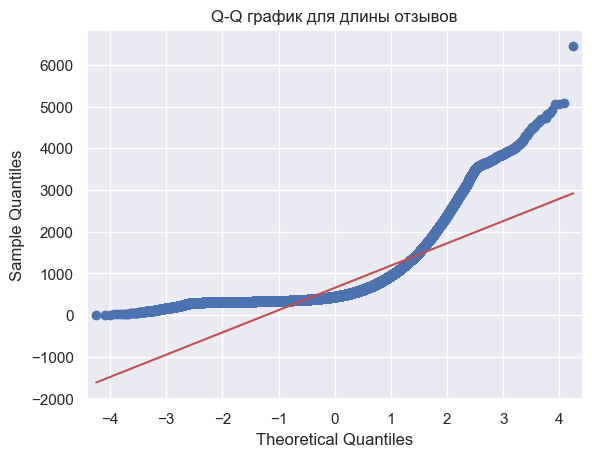

In [26]:
import statsmodels.api as sm

sm.qqplot(data['review_length'], line='s')
plt.title('Q-Q график для длины отзывов')
plt.show()


**Анализ Q-Q графика:**
- Как можно заметить точки лежат в хаотичном порядке, что может указывать на отклонения нормальности

**Что касается результатов теста Шапиро-Уилка, то они указывают на то, что `p-value` крайне мало (меньше 0.05), что позволяет отклонить нулевую гипотезу о нормальности данных.**

**Теперь, что касается корреляции между длинной отзывов и оценкой :)**
- На мой взгляд, в контексте данного корреляционного анализа, знания о нормальности распределения данных важны, но все же в этом случае корреляционные коэффициенты могут быть рассчитаны для данных с разными распределениями.

Поэтому перейдем к оценке корреляции между длинной отзывов и оценкой.

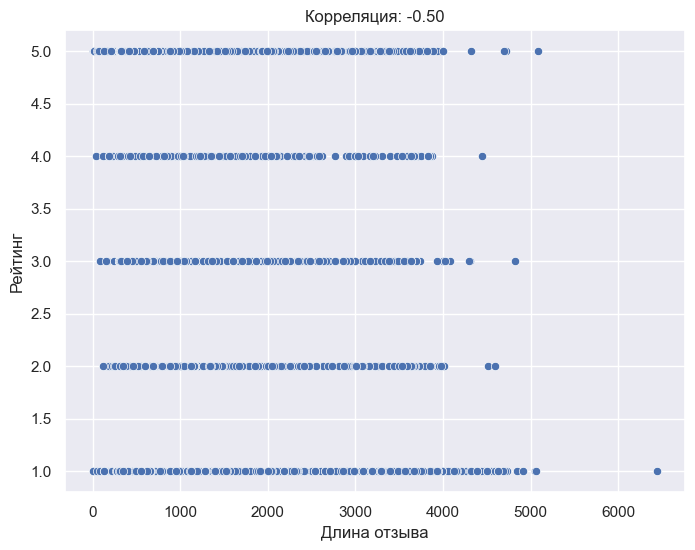

In [27]:
correlation = data['review_length'].corr(data['rating'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='review_length', y='rating')
plt.title(f'Корреляция: {correlation:.2f}')
plt.xlabel('Длина отзыва')
plt.ylabel('Рейтинг')
plt.show()

**Корреляция `-0,50` указывает на умеренную отрицательную линейную зависимость**

- **на диаграмме рассеяния можно увидеть незначительную нисходящую тенденцию, что указывает на то, что более короткие отзывы скорее склонны иметь более высокие оценки, а более длинные отзывы склонны иметь более низкие оценки.**

#### `1.3.3` Тематическое моделирование с применением LDA

**Тематическое моделирование с использованием метода `Latent Dirichlet Allocation` позволяет выделить темы в коллекции текстовых данных.**

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

stop_words = set(stopwords.words('russian'))
texts = data['body']
texts_token = texts.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha() and word not in stop_words])

dictionary = corpora.Dictionary(texts_token)
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [30]:
lda_display = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

**При помощи LDA алгоритма, были выделены несколько основных тематик отзывов:**
- **Тема 1 ->** связана с упоминанием банковских карт, денег, банка и других схожих слов (относиться к опыту использования банковских карт).
- **Тема 2 ->** представляет собой кластер слов, связанных с договорами, комиссией, задолжностям, погашениям и тд. (относиться к финансовым сделкам).
- **Дополнительно ->** Стоит отметить, что я нашел некоторую связь между словами благодарности (которые отражают положительную семантику) и словами "бесплатно", "кэшбек" и "быстрый". Вероятно клиенты выражают благодарность в контексте бесплатных услуг, кэшбека и быстрого обслуживания :D

# 2. Модель бинарной классификации отзывов <a class="anchor" id="02"></a>

**Для выполнения второй части задания, я бы хотел, немного поэксперементировать и обучить две модели бинарной текстовой классификации: с использованием `Логистической регрессии` и `RNN LSTM` на PyTorch.**

- Для треккинга экспериментов, я также буду использовать **MLflow**

### Подготовка данных

In [31]:
data_ml = data.copy()
data_ml.columns

Index(['body', 'title', 'rating', 'bank_name', 'date', 'info_rating',
       'review_length'],
      dtype='object')

**Отбросим ненужные столбцы**

In [32]:
data_ml = data_ml.drop(labels=['rating', 'bank_name', 'date', 'review_length'], axis=1)

In [33]:
data_ml.columns

Index(['body', 'title', 'info_rating'], dtype='object')

#### Лемматизация текста

In [34]:
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm.auto import tqdm
import nltk
import re


patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc, return_list=False):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    
    for token in doc.split():
        token = token.strip()
        
        if token and token not in stopwords_ru and token[0]!='@'  and not(token.isascii()):
            token = morph.normal_forms(token)[0]
            tokens.append(token)
            
    if len(tokens) > 0:
        return tokens if return_list else ' '.join(tokens)
    
    return None


<>:8: DeprecationWarning: invalid escape sequence '\]'
<>:8: DeprecationWarning: invalid escape sequence '\]'
C:\Users\nikdf\AppData\Local\Temp\ipykernel_24472\1765986086.py:8: DeprecationWarning: invalid escape sequence '\]'
  patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\nikdf\PycharmProjects\sberTechTask\venv\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\nikdf\PycharmProjects\sberTechTask\venv\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargsp

**Выполним лемматизацию, а также предобработку с использованием регулярных выражений, и сохраним в отдельный файлик :D**

In [35]:
tqdm.pandas()

data_ml['review_lemmatize'] = data_ml['body'].progress_apply(lemmatize)

data_ml.to_csv('../../src/data/preproc_banks_data.csv', encoding='utf-8', index=False)

  0%|          | 0/92673 [00:00<?, ?it/s]

In [36]:
df_ml = pd.read_csv("../../src/data/preproc_banks_data.csv", sep=',')
df_ml[['review_lemmatize', 'info_rating']]

,review_lemmatize,info_rating
0,добрый день писать сюда скорый разрешение вопр...,0
1,при возврат просрочить задолженность банк звон...,0
2,ю оформить кредитный карта день в банк открыти...,0
3,новый год начинаться приятность никогда понима...,1
4,увидеть сайт газпромбанк акция бонус кредитный...,0
...,...,...
92668,август обнаружить баланс уменьшиться в история...,0
92669,обратиться вопрос заказать первый кредитка у т...,1
92670,в август досрочно погасить ипотека кредитный д...,0
92671,оформить кредит покупка автомобиль салон станц...,0


**Как можно заметить, наши отзывы наконец-то приобрели приемлимый вид для векторизации, но сначала необходимо разбить нашу выборку на:**
- тренировочную
- тестовую
- валидационную соответственно

**разделение на подвыборки будет описано в каждом из экспериментов**

-----
# Интересное наблюдение
-----

**После выполнения лемматизации текста, я решил проверить сохранилась ли целостность данных.**

- **Проверка на пропуски:**

In [46]:
data_ml.isnull().sum()

body                0
title               0
info_rating         0
review_lemmatize    5
dtype: int64

- **Как можно заметить, есть 5 пропусков, глянем их:**

In [47]:
data_ml[data_ml.isnull().any(axis=1)]

,body,title,info_rating,review_lemmatize
2935,use undefined behavior.\n2022-12-27 22:42:18.1...,Jkkjjkjkjkkj,1,None
2936,state.prepareTextInputState(isTextEntering: an...,state.prepareTextInputState(isTextEntering: an...,1,None
2962,let actualized = answer.actualized(\n ...,Jkkkjjkj,1,None
3118,https://www.banki.ru/credit-master/anketa/purp...,Уааааааа,1,None
41144,"&lt;p&gt;My job is traveling, I&#039;m on whee...",Бонус,1,None


- **Видно, что в столбце `body` (который представляет собой сами отзывы) присутствует лишняя информация, которая не относится к содержанию отзывов.


- Удалим их, а также создадим новый файл CSV (С уже очищенными данными)

In [53]:
data_ml = data_ml.dropna()

data_ml.to_csv('../../src/data/banks_data_clean.csv', index=False)

In [54]:
data_ml.isnull().sum()

body                0
title               0
info_rating         0
review_lemmatize    0
dtype: int64

-----
## **Вывод**: 

**Благодаря препроцессингу данных удалось избежать их загрязнения и искажения, избавив столбец `body` от лишней информации :)**

-----

**Подгрузим данные**

In [56]:
data_exp = pd.read_csv("../../src/data/banks_data_clean.csv", sep=',')
df_ml[['review_lemmatize', 'info_rating']]

,review_lemmatize,info_rating
0,добрый день писать сюда скорый разрешение вопр...,0
1,при возврат просрочить задолженность банк звон...,0
2,ю оформить кредитный карта день в банк открыти...,0
3,новый год начинаться приятность никогда понима...,1
4,увидеть сайт газпромбанк акция бонус кредитный...,0
...,...,...
92668,август обнаружить баланс уменьшиться в история...,0
92669,обратиться вопрос заказать первый кредитка у т...,1
92670,в август досрочно погасить ипотека кредитный д...,0
92671,оформить кредит покупка автомобиль салон станц...,0


#### О несбалансированности в данных

Для эффективной борьбы с дисбалансом классов, я решил воспользоваться методом **взвешивания классов** `class weight` (более сильные штрафы за ошибки в классе-меньшинстве), и вот почему:
- В отличие от **Oversampling**, который включает в себя генерацию синтетических данных или дублирование существующих, взвешивание классов не требует изменения размера набора данных. Следовательно, это позволит избежать потенциальных проблем с неадекватным отражением реальных данных, а также сохранит ценные наблюдения.
- Следующий `**Undersampling**, может привести к потере важных данных, что плохо отразится на обобщающей способности модели в контексте моей задачи.
- И **кросс-валидация с учетом стратификации** (обеспечение правильного распределения классов в каждом фолде)


#### Выбор метрики

Я выбирал между `F1-score` и `AUC-ROC`, но в конечном счете остановился на **F1-score**, потому что данная метрика лучше подходит для задач с дисбалансом данных в классах, засчет того, что она объединяет в себе точность и полноту.

### Эксперимент №1: С применением алгоритма Logistic Regression

**Разделим выборку**

In [57]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

train_data, test_valid_data = train_test_split(data_exp, test_size=0.2, random_state=42)
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

**Выполним векторизацию текста**

In [58]:
train_data['review_lemmatize'].isnull().sum()

0

In [59]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_data['review_lemmatize'])
X_valid = vectorizer.transform(valid_data['review_lemmatize'])
X_test = vectorizer.transform(test_data['review_lemmatize'])

y_train = train_data['info_rating']
y_valid = valid_data['info_rating']
y_test = test_data['info_rating']

**Обучим модель**

In [60]:
model = LogisticRegression()

# Определение параметров для поиска по сетке
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'class_weight': [None, 'balanced']}

# Определение метрики для оптимизации (F1 Score)
scorer = make_scorer(f1_score)

# Инициализация GridSearchCV
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=5)

# Запуск поиска по сетке
grid_search.fit(X_train, y_train)

# Получение лучших гиперпараметров
best_params = grid_search.best_params_

# Оценка производительности на валидационном наборе с лучшими параметрами
y_pred = grid_search.predict(X_valid)
f1 = f1_score(y_valid, y_pred)

Best Parameters: {'C': 1, 'class_weight': None}
F1 Score on Validation Set: 0.9809336884901163


**Оценка на валидационном наборе и на тестовом наборе, а также вывод лучших гиперпараметров (которые были получены с помощью grid search**

In [70]:
best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)

f1_test = f1_score(y_test, y_pred_test)
print(f'Лучшие гиперпараметры: {Fore.MAGENTA}{best_params}{Style.RESET_ALL}')
print(f'\nF1 Score на валидационном наборе: {Fore.BLUE}{f1}{Style.RESET_ALL}')
print(f'F1 Score на тестовом наборе: {Fore.GREEN}{f1_test}{Style.RESET_ALL}')

Лучшие гиперпараметры: {'C': 1, 'class_weight': None}

F1 Score на валидационном наборе: 0.9809336884901163
F1 Score на тестовом наборе: 0.9809464421811127


**Визуализируем матрицу ошибок**

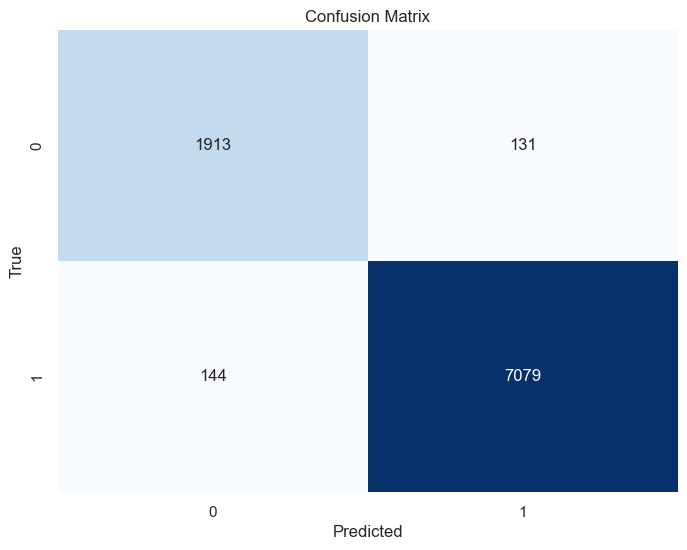

In [71]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные')
plt.ylabel('True')
plt.title('Матрица ошибок')
plt.show()

**Вывод:**
- Сначала по матрице ошибок
    - 1913 (TN): Модель правильно классифицировала 1913 отрицательных отзывов как отрицательные.
    - 7079 (TP): Модель правильно классифицировала 7079 положительных отзывов как положительные.
    - 131 (FP): Модель ошибочно классифицировала 131 отрицательных отзывов как положительные.
    - 144 (FN): Модель ошибочно классифицировала 144 положительных отзывов как отрицательные.

На мой взгляд, для относительно простого алгоритма `Logistic regression` результат неплохой.

- Теперь, что касается оценки на валидационном наборе и на тестовом, а также вывода лучших гиперпараметров (которые были получены с помощью grid search
    - F1-score, полученный на валидационной выборке, составил `0.9809`, а на тестовой выборке - `0.9809`. Это говорит о том, что модель обладает неплохой обобщающей способностью и хорошо обучилась.
    - grid search в качестве лучших гиперпараметров выбрал: 

### Эксперимент №2: На PyTorch с применением RNN LSTM

#### Импортирование модулей

In [ ]:
import torch


from torchtext.data import Field, TabularDataset, BucketIterator


import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

**Выбираем графический процессор в качестве устройства для вычислений**

In [82]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device.type

'cuda'

In [ ]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=df_ml, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

**Структура модели**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# Вывод